<a href="https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Assignment_06/Assignment_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workspace Initialization

## Libraries & Standard Setup

In [4]:
!pip install jupyterthemes

In [0]:
%matplotlib inline

import os

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# jt themes
from jupyterthemes import jtplot

# IPython display
from IPython.display import display

from scipy.io import loadmat # for loading .MAT files
import urllib.request

In [0]:
import tensorflow as tf
import time

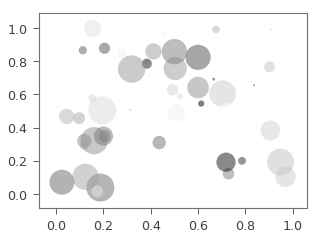

In [6]:
# Test Theme
!jt -t grade3 -f fira -fs 115
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Looks good. Let's roll.

In [0]:
# santatize Dataset
def santatize_set( dataframe ):
    if dataframe.isnull().values.any() == True:
        cleaned = dataframe.dropna()
        print('Dropped {} invalid samples'.format(dataframe.count - cleaned.count))
        dataframe = cleaned
    return dataframe

In [0]:
# saves a plot for reporting later. 
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Graphical Utility

Get an image from TensorFlow MNIST dataset.

In [0]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

# Project Dataset

## MNIST Retrieval

Use the MNIST dataset from TensorFlow.

In [0]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

## MNIST Exploration

### Digits

Let's grab some random images and inspect them.

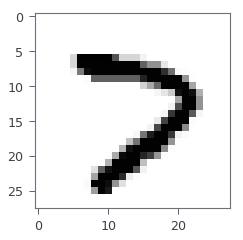

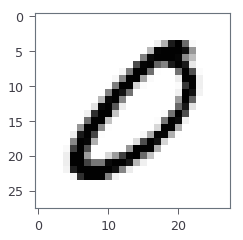

In [247]:
batch_xs, batch_ys = mnist.test.next_batch(2)

gen_image(batch_xs[0]).show()
gen_image(batch_xs[1]).show()

Let's grab a few more random images and display a grid so we can get a sense of the overall structure.

# Model Initialization

## Network Parameters

In [0]:
n_hidden_1 = 20 # 1st layer number of neurons
n_hidden_2 = 20 # 2nd layer number of neurons 
n_hidden_3 = 20 # 3rd layer number of neurons
n_hidden_4 = 20 # 4th layer number of neurons
n_hidden_5 = 20 # 5th layer number of neurons
n_input = 784   # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)

## Graph Preparation

In [0]:
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

Store layers, weights and bias.

## Weights

In [0]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5])),
    'out': tf.Variable(tf.random_normal([n_hidden_5, n_classes]))
}

## Biases

In [0]:
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'b5': tf.Variable(tf.random_normal([n_hidden_5])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

## Multilayer Perceptron Model

Create the multilayer perception model.

In [0]:
def multilayer_perceptron(x, weights, biases):
    # Hidden fully connected layer with neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.leaky_relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.leaky_relu(layer_2)
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.leaky_relu(layer_3)
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.leaky_relu(layer_4)
    layer_5 = tf.add(tf.matmul(layer_4, weights['h5']), biases['b5'])
    layer_5 = tf.nn.leaky_relu(layer_5)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_5, weights['out']) + biases['out']
    return out_layer

In [0]:
logits = multilayer_perceptron(X, weights, biases)

# Model Execution

Define the number of steps to display diagnostics.

In [0]:
display_step = 0

###  TensorFlow session to execute a end-to-end train & test cycle.

In [0]:
def run_model( weights, biases, learning_rate, training_epochs, batch_size ):

  logits = multilayer_perceptron(X, weights, biases)

  model_metrics = {}

  # Optimizer
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

  model_metrics['learning_rate'] = learning_rate

  # Loss

  loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      logits=logits, labels=Y))

  train_op = optimizer.minimize(loss_op)

  model_metrics['learning_rate'] = learning_rate

  init = tf.global_variables_initializer()

  with tf.Session() as sess:
      sess.run(init)

      saver = tf.train.Saver()

      start_time = time.clock()

      model_metrics['training_epochs'] = training_epochs

      model_metrics["epoches"] = []

      # Training cycle
      for epoch in range(training_epochs):

          avg_cost = 0.
          total_batch = int(mnist.train.num_examples/batch_size)
          model_metrics['total_batch'] = total_batch

          # Loop over all batches
          for i in range(total_batch):
              batch_x, batch_y = mnist.train.next_batch(batch_size)
              # Run optimization op (backprop) and cost op (to get loss value)
              _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x,
                                                              Y: batch_y})
              # Compute average loss
              avg_cost += c / total_batch

          
          model_metrics["epoches"].append((epoch+1, avg_cost))
          
          # Display logs per epoch step
          if display_step != 0 and epoch % display_step == 0:
              display("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))

      model_metrics['avg_cost'] = avg_cost

      end_time = time.clock()

      runtime = end_time - start_time  # seconds of wall-clock time 
      model_metrics['run_time'] = runtime

      # Apply Softmax to logits
      pred = tf.nn.softmax(logits)

      # Calculate Accuracy

      correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
      model_metrics['correct_prediction'] = correct_prediction

      accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
      model_metrics['accuracy'] = accuracy
      
      model_metrics['train_accuracy'] = sess.run(accuracy, feed_dict={X: batch_x,
                                    Y: batch_y})
        
      model_metrics['testing_accuracy'] = sess.run(accuracy, feed_dict={X: mnist.test.images,
                                        Y: mnist.test.labels})
      
      return model_metrics

# Model Evaluation & Benchmark

In [0]:
# Default / baseline
learning_rate = 0.0001
training_epochs = 10
batch_size = 10

Run the model in the baseline setup.

In [0]:
baseline_model = run_model( weights, biases, learning_rate = 0.0001, training_epochs = 10, batch_size = 10 )

In [0]:
model_v2 = run_model( weights, biases, learning_rate = 0.0001, training_epochs = 10, batch_size = 10 )

In [257]:
model_v3 = run_model( weights, biases, learning_rate = 0.01, training_epochs = 500, batch_size = 500 )

{'accuracy': <tf.Tensor 'Mean_60:0' shape=() dtype=float32>,
 'avg_cost': 0.0496249186975712,
 'correct_prediction': <tf.Tensor 'Equal_32:0' shape=(?,) dtype=bool>,
 'epoches': [(1, 307.3065018393779),
  (2, 17.988549423217773),
  (3, 6.796274896101521),
  (4, 3.956680870056153),
  (5, 2.792643356323243),
  (6, 2.116216961904005),
  (7, 1.6747753858566283),
  (8, 1.418071698058735),
  (9, 1.2584932912479752),
  (10, 1.164622184363278),
  (11, 1.0750481031157755),
  (12, 1.0135645508766173),
  (13, 1.0032992866906247),
  (14, 0.9656077894297516),
  (15, 0.9088678392496975),
  (16, 0.8696760508147148),
  (17, 0.8438437293876301),
  (18, 0.8096489749171523),
  (19, 0.7862046295946293),
  (20, 0.7772574798627331),
  (21, 0.7403971986337141),
  (22, 0.728098487854004),
  (23, 0.6952101019295777),
  (24, 0.675619172508066),
  (25, 0.6651068980043587),
  (26, 0.6299811552871354),
  (27, 0.6404991065913979),
  (28, 0.6026559054851531),
  (29, 0.5848753869533538),
  (30, 0.5713707558133385),
  

In [0]:
model_v4 = run_model( weights, biases, learning_rate = 0.01, training_epochs = 1000, batch_size = 100 )

# Summary.

Helper utility to extract relevant model metrics.

In [0]:
def get_model_df(name, model):
  values_df = pd.DataFrame(columns=list(('avg_cost', 'learning_rate', 'run_time','testing_accuracy','train_accuracy')))
  values_df.loc[0] = [model[x] for x in ('avg_cost', 'learning_rate', 'run_time','testing_accuracy','train_accuracy')]
  values_df['name'] = name
  return values_df

Convert model metrics into a single dataframe.

In [0]:
baseline_df = get_model_df('Baseline', baseline_model)
model_v2_df = get_model_df('Version 2', model_v2)
model_v3_df = get_model_df('Version 3', model_v3)
model_v4_df = get_model_df('Version 4', model_v4)

In [0]:
results = pd.concat([baseline_df, model_v2_df, model_v3_df, model_v4_df]).set_index('name')

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


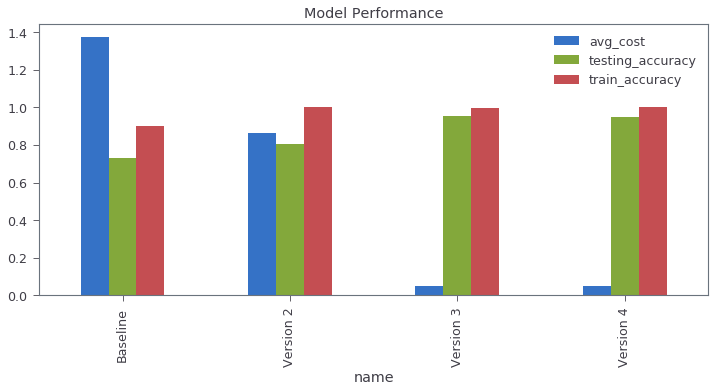

In [355]:
results.plot(y = ['avg_cost', 'testing_accuracy','train_accuracy'], title = "Model Performance", kind = "bar", figsize=(12, 5), use_index = True)
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


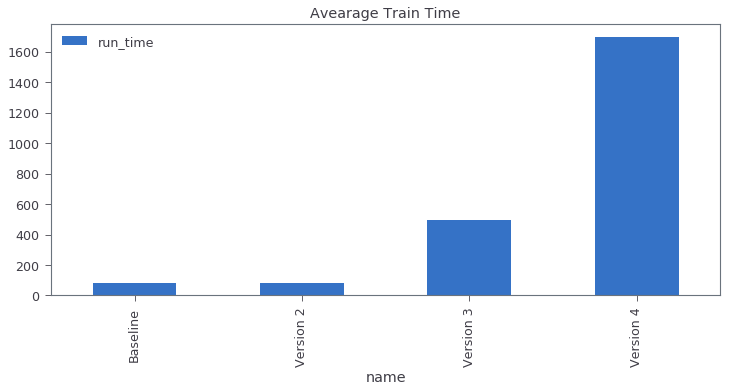

In [353]:
results.plot(y = ['run_time'], kind = "bar", title ="Avearage Train Time", figsize=(12, 5), use_index = True)
plt.show()

In [343]:
results

,avg_cost,learning_rate,run_time,testing_accuracy,train_accuracy
name,,,,,
Baseline,1.375902,0.0001,83.038120,0.7328,0.900
Version 2,0.861762,0.0001,84.441707,0.8071,1.000
Version 3,0.049625,0.0100,495.129222,0.9557,0.996
Version 4,0.052633,0.0100,1699.732041,0.9476,1.000
